## Table Of Contents
* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Analyze the dataset](#section-5)
* [Fit a Random-forest model](#section-6)
* [Analyzing Results](#section-7)
* [Save the model to GCS path](#section-8)
* [Create a model in Vertex-AI](#section-9)
* [Create an Endpoint](#section-10)  
* [What-If tool ](#section-11)
* [Cleaning up](#section-12)
    







## Overview
<a name="section-1"></a>


This managed-instance notebook provides a tutorial on building, deploying and analyzing predictions from a simple [Random-Forest](https://en.wikipedia.org/wiki/Random_forest) model using tools like like Sklearn, Vertex-AI and What-IF Tool ([WIT](https://cloud.google.com/ai-platform/prediction/docs/using-what-if-tool)) on a Synthetic Fraud Transcation dataset to solve a financial fraud detection problem. 


## Dataset
<a name="section-2"></a>


The dataset used in this tutorial is publicly availabe as the following Kaggle dataset. Further details about the dataset can be found at the corresponding page. 
- [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/ealaxi/paysim1)


## Objective
<a name="section-3"></a>


This tutorial demonstrates data-analysis and model building on a synthetic financial dataset. The model will be trained on identifying fraudulent cases among the transactions. Further, the trained model is deployed on Vertex-AI Endpoints and analyzed using What-If Tool. In detail, the steps taken in this tutorial are as follows : 

- Installation of required libraries
- Reading the dataset from Cloud-storage bucket
- Performing Exploratory Analysis on the dataset
- Preprocessing the dataset
- Training a Random-Forest model using sklearn
- Saving the model to a Cloud-storage bucket
- Creating a Vertex-AI model resource and deploying to an endpoint
- Running the What-If Tool on test data
- Un-deploying the model and cleaning up the model resources


## Costs
<a name="section-4"></a>


This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage. 

## Kernel Configuration

Select the Tensorflow kernel while running this notebook on Vertex-AI's managed instances. Tensorflow kernel comes with the What-IF tool installed and configured by default.

## Installation

In [ ]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

USER_FLAG = ""
# Google Cloud Notebook requires dependencies to be installed with '--user'
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

Install the latest version of the Vertex AI client library.

Run the following command in your virtual environment to install the Vertex SDK for Python:

In [ ]:
! pip install {USER_FLAG} --upgrade google-cloud-aiplatform

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**


When you create a model in Vertex-AI using the Cloud SDK, you give a Cloud Storage path where the trained model is saved. 
In this tutorial, Vertex AI saves the trained model to a GCS bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [40]:
BUCKET_NAME = "gs://vertex_ai_managed_services_demo"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

### Copy dataset into your Cloud Storage bucket (optional)

Add the <b>PS_20174392719_1491204439457_log.csv</b> file from the "[Synthetic Financial Datasets for Fraud detection](https://www.kaggle.com/ealaxi/paysim1)" Kaggle competition page to the created bucket. This step is optional and if needed the data can be loaded into the local notebook environment itself and be read using pandas. The file-paths can be adjusted in such a case.

In Vertex-ai's managed instances, file upload to a GCS bucket can be performed using the GCS browser pane from the Jupyter Lab environment itself. It also supports all the other operations like rename, delete, download etc. without the hassle of writing any code or going to the Cloud Storage UI.

## Tutorial

### Import required libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import joblib 
from google.cloud import storage

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load dataset
if BUCKET_NAME == "":
    FILE_PATH = "[local-file-path]"
else : 
    FILE_PATH = BUCKET_NAME + "/" + "fraud_detection/PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(FILE_PATH)

## Analyze the dataset
<a name="section-5"></a>


Take a quick look at the dataset and the number of rows.

In [76]:
print ("shape : ",df.shape)
df.head()

shape :  (6362620, 8)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


Check for null values

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Check the type of transactions involved

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Text(0, 0.5, 'Amount')

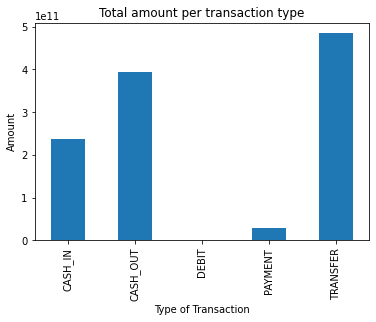

In [7]:
print(df.type.value_counts())
var = df.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount')

## Working with imbalanced data

Althuogh the outcome variable "isFraud" seems to be very imbalanced in the current dataset, a base model can be trained on it to check the quality of fraudulent transactions in the data and further if needed, counter measures like undersampling of majority class or oversampling of the minority class can be considered.

In [8]:
# Count number of fraudulent/non-fraudulent transactions
df.isFraud.value_counts() 

0    6354407
1       8213
Name: isFraud, dtype: int64

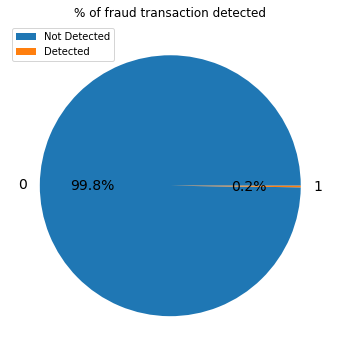

In [9]:
piedata = df.groupby(['isFlaggedFraud']).sum()
f, axes = plt.subplots(1,1, figsize=(6,6))
axes.set_title("% of fraud transaction detected")
piedata.plot(kind='pie',y='isFraud',ax=axes, fontsize=14,shadow=False,autopct='%1.1f%%');
axes.set_ylabel('');
plt.legend(loc='upper left',labels=['Not Detected','Detected'])
plt.show()

## Prepare data for modeling
To prepare the dataset for training a few columns need to be dropped that contain either unique data ('nameOrig','nameDest') or redundant fields ('isFlaggedFraud'). The categorical field "type" which describes the type of transaction and is important for fraud detection needs to be one-hot encoded.


In [10]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

In [11]:
X = pd.concat([df.drop('type', axis=1), pd.get_dummies(df['type'])], axis=1)
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


Remove the outcome variable from the training data

In [12]:
y = X[['isFraud']]
X = X.drop(['isFraud'],axis=1)

Split the data and assign 70% for training and 30% for testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42, shuffle=False)
print (X_train.shape, X_test.shape)

(4453834, 11) (1908786, 11)


## Fit a Random-forest model
<a name="section-6"></a>

Fit a simple Random-Forest classifier on the preprocessed train dataset.

In [14]:
%%time
forest=RandomForestClassifier()
forest.fit(X_train,y_train)

CPU times: user 13min 23s, sys: 11.9 s, total: 13min 35s
Wall time: 13min 35s


RandomForestClassifier()

## Analyzing Results
<a name="section-7"></a>
The model returns good scores but the confusion matrix really brings the point home that this model can indeed work with imbalanced data.

In [15]:
y_prob=forest.predict_proba(X_test)
y_pred=forest.predict(X_test)

print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
print('F1 - score :',(f1_score(y_test,y_pred)))

print('Confusion_matrix : ')
print(confusion_matrix(y_test,y_pred))

print("classification_report")
print(classification_report(y_test,y_pred))

AUPRC : 0.9262423531701122
F1 - score : 0.8523607294529103
Confusion_matrix : 
[[1904192      24]
 [   1158    3412]]
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       0.99      0.75      0.85      4570

    accuracy                           1.00   1908786
   macro avg       1.00      0.87      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



Use RandomForestClassifier feature_importances_ function to get an better understanding about which features were the most useful to the model.

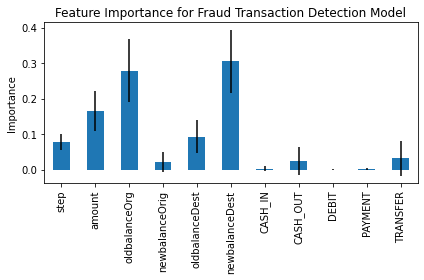

In [16]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X_train))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance for Fraud Transaction Detection Model")
ax.set_ylabel("Importance")
fig.tight_layout()

## Save the model to GCS path
<a name="section-8"></a>

In [17]:
## save the trained model to a local file "model.joblib"
FILE_NAME = "model.joblib"
joblib.dump(forest, FILE_NAME)

# Upload the saved model file to GCS
BUCKET_NAME = "your-bucket-name"
BLOB_PATH = "your-blob-path"
BLOB_NAME = BLOB_PATH + FILE_NAME

bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename("model.joblib")

## Create a model in Vertex-AI
<a name="section-9"></a>

In [20]:
REGION = "your-region"
MODEL_DISPLAY_NAME = "your-model-display-name"
ARTIFACT_GCS_PATH = f'gs://{BUCKET_NAME}/{BLOB_PATH}'

In [21]:
! gcloud beta ai models upload \
  --region=$REGION \
  --display-name=$MODEL_DISPLAY_NAME \
  --container-image-uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest" \
  --artifact-uri=$ARTIFACT_GCS_PATH

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [4008940066272444416]...done.                            


Get the MODEL_ID from the created model.

In [22]:
! gcloud beta ai models list \
  --region $REGION \
  --filter=display_name=$MODEL_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
MODEL_ID             DISPLAY_NAME
6994785112655134720  fraud-detection-model


In [23]:
MODEL_ID = "6994785112655134720"

## Create an Endpoint
<a name="section-10"></a>

In [24]:
ENDPOINT_DISPLAY_NAME = "your-endpoint-display-name"

In [25]:
! gcloud beta ai endpoints create \
  --region=$REGION \
  --display-name=$ENDPOINT_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [8429786050490007552]...done.                            
Created Vertex AI endpoint: projects/931647533046/locations/us-central1/endpoints/5443145507444621312.


Verify that the endpoint has been created and save the ENDPOINT_ID.

In [26]:
! gcloud beta ai endpoints list \
  --region=$REGION \
  --filter=display_name=$ENDPOINT_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ENDPOINT_ID          DISPLAY_NAME
5443145507444621312  fraud-detection-model-ep1


In [27]:
ENDPOINT_ID = "5443145507444621312"

### Deploy the model to the created endpoint

Configure the depoyment name, machine-type and other parameters for the deployment.

In [28]:
DEPLOYED_MODEL_NAME = "your-deployed-model-name"
MACHINE_TYPE = "your-machine-type"

In [29]:
! gcloud beta ai endpoints deploy-model $ENDPOINT_ID\
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$DEPLOYED_MODEL_NAME \
  --machine-type=$MACHINE_TYPE \
  --traffic-split=0=100

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [7945086140594257920]...done.                            
Deployed a model to the endpoint 5443145507444621312. Id of the deployed model: 1375647376022175744.


Save the ID of the deployed model

In [30]:
DEPLOYED_MODEL_ID = "1375647376022175744"

## What-If tool 
<a name="section-11"></a>
What-If Tool can be used to analyze the model predictions on a test data. A brief introduction to the What-If Tool can be found [here](https://pair-code.github.io/what-if-tool/). In the current tutorial, What-If Tool will be configured and run on the model trained locally and also the model deployed on Vertex-AI Endpoints in the earlier steps.

[WitConfigBuilder](https://github.com/PAIR-code/what-if-tool/blob/master/witwidget/notebook/visualization.py#L30) provides the  **set_ai_platform_model()** method to configure the WIT with a model deployed as a version on Ai-Platform models. This feature currently supports Ai-Platform only but not Vertex-AI models. Fortunately, there is also an option to pass a custom function for generating predictions through the **set_custom_predict_fn()** method where either the locally trained model or a function that returns predictions from a Vertex-AI model can be passed.

### Prepare test samples

Save some samples from the test-data for both the availble classes(Fraud/not-Fraud) to analyze the model using What-If Tool.

In [77]:
## collect 50 samples for each class-label from the test data
pos_samples = y_test[y_test['isFraud'] == 1].sample(50).index
neg_samples = y_test[y_test['isFraud'] == 0].sample(50).index
test_samples_y = pd.concat([y_test.loc[pos_samples], y_test.loc[neg_samples]])
test_samples_X = X_test.loc[test_samples_y.index].copy()

### Running What-If tool on the local model

In [74]:
import numpy as np
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

# define target and labels
TARGET_FEATURE = 'isFraud'
LABEL_VOCAB = ['not-fraud', 'fraud']

# define the function to adjust the predictions
def adjust_prediction(pred):
    return [1 - pred, pred]

# Combine the features and labels into one array for the What-if Tool
test_examples = np.hstack((test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1,1)))

# Configure the WIT to run on the locally trained model
config_builder = (WitConfigBuilder(test_examples.tolist(), test_samples_X.columns.tolist() + ['isFraud'])
  .set_custom_predict_fn(forest.predict_proba)
  .set_target_feature(TARGET_FEATURE)
  .set_label_vocab(LABEL_VOCAB))

# display the WIT widget
WitWidget(config_builder, height=600)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['not-fraud', 'fraud'], 'feature_names': ['st…

### Running What-If tool on the deployed Vertex-AI model

In [72]:
from google.cloud import aiplatform

# configure the deployed model
PROJECT_ID = 'your-project-id'
aiplatform.init(project=PROJECT_ID, location=REGION)
endpoint = aiplatform.Endpoint(ENDPOINT_ID)

# configure the target and class-labels
TARGET_FEATURE = 'isFraud'
LABEL_VOCAB = ['not-fraud', 'fraud']

# function to return predictions from the deployed Model
def endpoint_predict_sample(instances: list):
    prediction = endpoint.predict(instances=instances)
    preds = [[1-i, i] for i in prediction.predictions]
    return preds

# Combine the features and labels into one array for the What-if Tool
test_examples = np.hstack((test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1,1)))

# Configure the WIT with the prediction function
config_builder = (WitConfigBuilder(test_examples.tolist(), test_samples_X.columns.tolist() + ['isFraud'])
  .set_custom_predict_fn(endpoint_predict_sample)
  .set_target_feature(TARGET_FEATURE)
  .set_label_vocab(LABEL_VOCAB))

# run the WIT-widget
WitWidget(config_builder, height=400)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['not-fraud', 'fraud'], 'feature_names': ['st…

## Cleaning up
<a name="section-12"></a>


To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [78]:
# Undeploy the model resource
! gcloud ai endpoints undeploy-model $ENDPOINT_ID --deployed-model-id=$DEPLOYED_MODEL_ID --quiet --region=$REGION

# Delete endpoint resource
! gcloud ai endpoints delete $ENDPOINT_ID --quiet --region=$REGION

# Delete model resource
! gcloud ai models delete $MODEL_ID --quiet --region=$REGION

# Delete Cloud Storage objects that were created
# gsutil -m rm -r $BUCKET_NAME

E1001 20:26:12.026856142     744 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1633119972.026677189","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1633119972.026668917","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":957,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
